In [1]:
import torch
import torchvision
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from dataset import LEVIRCDDataset
from utils import *

##### Train data

In [3]:
#train data
image_dir_A_train = '../data/lesson_1/train/A/'
image_dir_B_train = '../data/lesson_1/train/B/'
label_dir_train = '../data/lesson_1/train/label/'

#validation data
image_dir_A_val = '../data/lesson_1/val/A/'
image_dir_B_val = '../data/lesson_1/val/B/'
label_dir_val = '../data/lesson_1/val/label/'

#test data
image_dir_A_test = '../data/lesson_1/test/A/'
image_dir_B_test = '../data/lesson_1/test/B/'
label_dir_test = '../data/lesson_1/test/label/'


In [4]:
#defining the transformation 
#expreimentation block
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=transform)
traindataloader = DataLoader(levir_cd_dataset_train, batch_size=8, shuffle=True)

In [6]:
(image_A, image_B), label = next(iter(traindataloader))

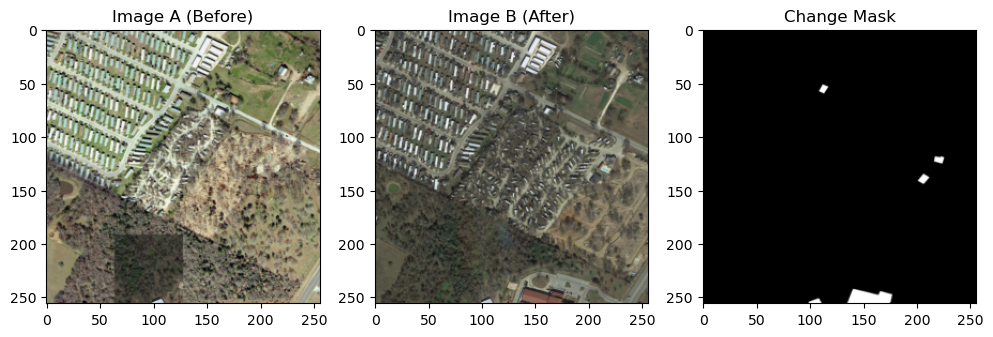

In [7]:
show_images(image_A[0], image_B[0], label[0])

In [9]:
# Instantiate the model
model = UNet(in_channels=6, out_channels=1)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=transform)
levir_cd_dataset_val = LEVIRCDDataset(image_dir_A_val, image_dir_B_val, label_dir_val, transform=transform)
levir_cd_dataset_test = LEVIRCDDataset(image_dir_A_test, image_dir_B_test, label_dir_test, transform=transform)


# DataLoader (assuming you've already created the DataLoader as discussed previously)
train_loader = DataLoader(levir_cd_dataset_train, batch_size=16, shuffle=True, num_workers=4)
validate_loader = DataLoader(levir_cd_dataset_val, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(levir_cd_dataset_test, batch_size=16, shuffle=False, num_workers=4)


In [ ]:
train_model(model, criterion, optimizer, train_loader, validate_loader, num_epochs=50)

In [15]:
model = UNet(in_channels=6, out_channels=1).to(device)
model.load_state_dict(torch.load('../data/lesson_1/model_weights/unet_best_model.pth'))
epoch_loss, mean_iou, mean_dice = validate_model(model, test_loader)
print(f'Loss: {epoch_loss:.4f}, IoU: {mean_iou:.4f}, DICE: {mean_dice:.4f}')

Loss: 0.0451, IoU: 0.5629, DICE: 0.6692


In [230]:
def compute_iou(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def compute_dice(pred, target):
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

def visualize_test_results(model, test_loader, num_examples=5):
    model.eval()
    with torch.no_grad():
        for i, ((image_A, image_B), labels) in enumerate(test_loader):
            if i >= num_examples:
                break
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            inputs = torch.cat([image_A, image_B], dim=1)
            outputs = model(inputs)
            outputs = (outputs > 0.5).float()

            # Plot the results
            for j in range(min(len(image_A), num_examples)):
                plt.figure(figsize=(10, 4))
                
                plt.subplot(1, 4, 1)
                plt.imshow(image_A[j].cpu().permute(1, 2, 0))
                plt.title("Image A (Before)")
                
                plt.subplot(1, 4, 2)
                plt.imshow(image_B[j].cpu().permute(1, 2, 0))
                plt.title("Image B (After)")

                plt.subplot(1, 4, 3)
                plt.imshow(labels[j].cpu().squeeze(), cmap='gray')
                plt.title("GT Change Mask")
                
                plt.subplot(1, 4, 4)
                plt.imshow(outputs[j].cpu().squeeze(), cmap='gray')
                iou = compute_iou(outputs[j], labels[j])
                dice = compute_dice(outputs[j], labels[j])
                plt.title("Predicted Change Mask (IoU: {:.4f}, DICE: {:.4f})".format(iou, dice))
                plt.show()


In [ ]:
visualize_test_results(model, test_loader, num_examples=5)

In [ ]:
def visualize_failed_cases(model, test_loader, iou_threshold=0.5, num_examples=5):
    model.eval()
    failed_cases = []
    
    with torch.no_grad():
        for i, ((image_A, image_B), labels) in enumerate(test_loader):
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            inputs = torch.cat([image_A, image_B], dim=1)
            outputs = model(inputs)
            outputs = (outputs > 0.5).float()
            
            # Calculate IoU for each image in the batch
            intersection = (outputs * labels).sum(dim=[1, 2, 3])
            union = (outputs + labels).sum(dim=[1, 2, 3]) - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            
            for j in range(len(iou)):
                if iou[j] < iou_threshold:
                    failed_cases.append((image_A[j].cpu(), image_B[j].cpu(), outputs[j].cpu(), labels[j].cpu(), iou[j].item()))

    # Visualize some failed cases
    for i, (image_A, image_B, output, label, iou_score) in enumerate(failed_cases[:num_examples]):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 4, 1)
        plt.imshow(image_A.permute(1, 2, 0))
        plt.title("Image A (Before)")
        
        plt.subplot(1, 4, 2)
        plt.imshow(image_B.permute(1, 2, 0))
        plt.title("Image B (After)")
        
        plt.subplot(1, 4, 3)
        plt.imshow(output.squeeze(), cmap='gray')
        plt.title(f"Predicted Mask (IoU: {iou_score:.2f})")
        
        plt.subplot(1, 4, 4)
        plt.imshow(label.squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        
        plt.show()

# Visualize failed cases
visualize_failed_cases(model, test_loader, iou_threshold=0.5)


In [ ]:
def calculate_dice_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    smooth = 1e-6  # To avoid division by zero
    intersection = (pred * target).sum(dim=[1, 2, 3])
    dice = (2. * intersection + smooth) / (pred.sum(dim=[1, 2, 3]) + target.sum(dim=[1, 2, 3]) + smooth)
    return dice

def visualize_bad_cases_by_dice(model, test_loader, dice_threshold=0.7, num_examples=5):
    model.eval()
    bad_cases = []
    
    with torch.no_grad():
        for (image_A, image_B), labels in test_loader:
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            inputs = torch.cat([image_A, image_B], dim=1)
            outputs = model(inputs)
            
            # Calculate Dice score for each image in the batch
            dice_scores = calculate_dice_score(outputs, labels)
            
            for j in range(len(dice_scores)):
                if dice_scores[j] < dice_threshold:
                    bad_cases.append((image_A[j].cpu(), image_B[j].cpu(), outputs[j].cpu(), labels[j].cpu(), dice_scores[j].item()))

    # Visualize some bad cases
    for i, (image_A, image_B, output, label, dice_score) in enumerate(bad_cases[:num_examples]):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 4, 1)
        plt.imshow(image_A.permute(1, 2, 0))
        plt.title("Image A (Before)")
        
        plt.subplot(1, 4, 2)
        plt.imshow(image_B.permute(1, 2, 0))
        plt.title("Image B (After)")
        
        plt.subplot(1, 4, 3)
        plt.imshow(output.squeeze(), cmap='gray')
        plt.title(f"Predicted Mask (Dice: {dice_score:.2f})")
        
        plt.subplot(1, 4, 4)
        plt.imshow(label.squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        
        plt.show()

# Visualize bad cases by Dice score
visualize_bad_cases_by_dice(model, test_loader, dice_threshold=0.7)


- Model performs good, I will like to inspect more into what cases it failed exactly, and see if there is any pattern in them. 
- I want to use the same simple model, but want to add augmentation. The key augmentation that I want to add is using patches of 16x16. So dividing the picture into 16x16 and making prediction.
- Later I will use some methods like attention and see its effect. And then upgrade to newer model like SAM for the same purpose? 

- Original dataset has shape of 1024 x 1024, Lets not resize and pass it see the results: Not that good, but will come back to that.

#### Augmentations

- Now we will try to improve the model as much as we can with augmentaions, and will keep the model simple.
- Talking about augmentations, they need to be applied to all the three images that we have, Image before, image after and label. 
- Lets implement this. 

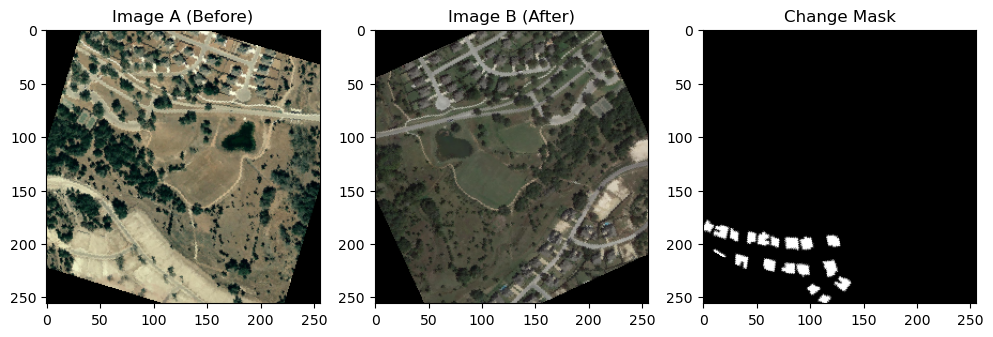

In [69]:
image_a = Image.open('../data/lesson_1/train/A/train_1.png').convert('RGB')
image_b = Image.open('../data/lesson_1/train/B/train_1.png').convert('RGB')
label = Image.open('../data/lesson_1/train/label/train_1.png').convert('L')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor()
])

transformed_image_a = transform(image_a)
transformed_image_b = transform(image_b)
transformed_label = transform(label)

show_images(transformed_image_a, transformed_image_b, transformed_label)

- Obvious mistake: not implementing same augmentation to all, this type of augmentation will be counter-productive. 

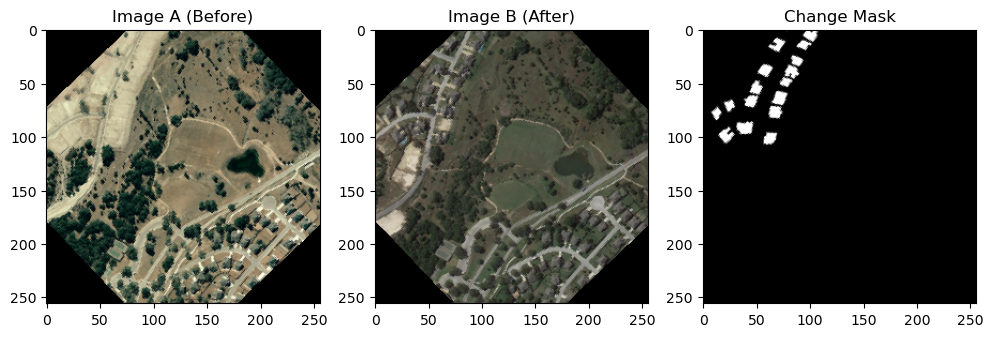

In [73]:
seed = torch.randint(0, 2**32, (1,)).item()

torch.manual_seed(seed)
transformed_image_a = transform(image_a)
torch.manual_seed(seed)
transformed_image_b = transform(image_b)
torch.manual_seed(seed)
transformed_label = transform(label)

show_images(transformed_image_a, transformed_image_b, transformed_label)


In [184]:
class PairTransformWithSeparateLabels:
    """Apply transformations to input images and separate transformations to labels."""
    def __init__(self, image_transform, label_transform, p = 0.2):
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
        self.p = p
    
    def __call__(self, imgA, imgB, label):
        seed = torch.randint(0, 2**32, (1,)).item()  # Seed for random operations
        torch.manual_seed(seed)
        
        # Apply the same transform to both input images
        if torch.rand(1).item() < self.p:
            torch.manual_seed(seed)
            imgA = self.color_jitter(imgA)
            imgA = self.gaussian_blur(imgA)
            imgB = self.color_jitter(imgB)
            imgB = self.gaussian_blur(imgB)
        
        torch.manual_seed(seed)
        imgA = self.image_transform(imgA)
        
        torch.manual_seed(seed)
        imgB = self.image_transform(imgB)
        
        # Apply only geometric transforms to the label
        torch.manual_seed(seed)
        label = self.label_transform(label)
        
        return imgA, imgB, label

class Valid_transform:
    def __init__(self, val_transform):
        self.val_transform = val_transform
    def __call__(self, imgA, imgB, label):
        imgA = self.val_transform(imgA)
        imgB = self.val_transform(imgB)
        label = self.val_transform(label)
        return imgA, imgB, label


class LEVIRCDDataset(Dataset):
    def __init__(self, image_dir_A, image_dir_B, label_dir, transform=None):
        self.image_dir_A = image_dir_A
        self.image_dir_B = image_dir_B
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = os.listdir(image_dir_A)
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name_A = os.path.join(self.image_dir_A, self.image_filenames[idx])
        img_name_B = os.path.join(self.image_dir_B, self.image_filenames[idx])
        label_name = os.path.join(self.label_dir, self.image_filenames[idx])
        
        image_A = Image.open(img_name_A).convert("RGB")
        image_B = Image.open(img_name_B).convert("RGB")
        label = Image.open(label_name).convert("L")
        
        if self.transform:
            image_A, image_B, label = self.transform(image_A, image_B, label)
        
        return (image_A, image_B), label
    


In [220]:
# Define the augmentations for images
image_augmentations = transforms.Compose([
    transforms.RandomCrop(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-45, 45)),
    # transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Define the augmentations for labels (only geometric)
label_augmentations = transforms.Compose([
    transforms.RandomCrop(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-45, 45)),
    # transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

pair_transform_with_separate_labels = PairTransformWithSeparateLabels(image_augmentations, label_augmentations, p=0.2)

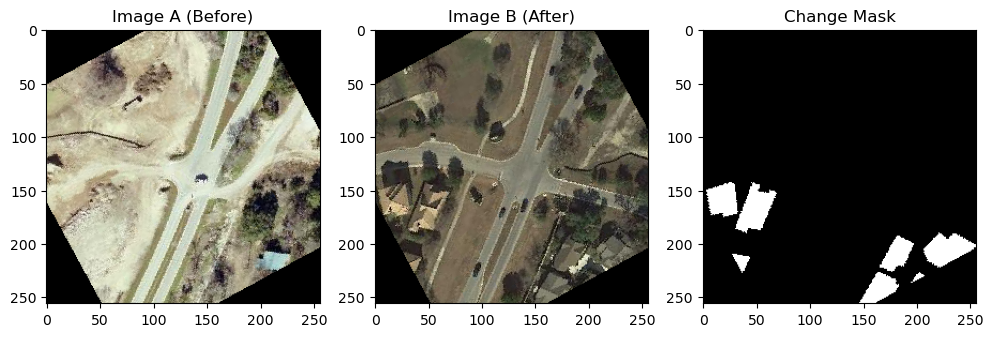

In [221]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=pair_transform_with_separate_labels)
traindataloader = DataLoader(levir_cd_dataset_train, batch_size=8, shuffle=True)
(image_A, image_B), label = next(iter(traindataloader))
show_images(image_A[0], image_B[0], label[0])

- Now its wokring as it is supposed to be.

In [214]:
def get_patches(image, patch_size=256, stride=256):
    """Divide the 6-channel image into patches of patch_size."""
    patches = image.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    patches = patches.contiguous().view(-1, 6, patch_size, patch_size)  # 6-channel input (Image A and B)
    num_patches = patches.size(0)
    return patches, num_patches

# Function to predict on each patch using DataLoader for batch processing
def predict_patches(model, patches, device, batch_size=16):
    """Predict on all patches using DataLoader and return the patch predictions."""
    dataset = TensorDataset(patches)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    all_predictions = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch[0].to(device)  # DataLoader returns batches as tuples
            predictions = model(batch)
            all_predictions.append(predictions.cpu())
    
    all_predictions = torch.cat(all_predictions, dim=0)
    return all_predictions

# Function to reconstruct the full-sized prediction from patch predictions
def reconstruct_image(patch_predictions, image_size=1024, patch_size=256, stride=256):
    """Reconstruct the full image from patch predictions."""
    num_patches_per_dim = (image_size + stride - 1) // stride  # Calculate the number of patches per dimension
    output_image = torch.zeros((1, 1, image_size, image_size))  # Assuming single-channel output
    weight = torch.zeros((1, 1, image_size, image_size))  # To handle overlapping regions
    
    idx = 0
    for i in range(0, image_size, stride):
        for j in range(0, image_size, stride):
            output_image[:, :, i:i+patch_size, j:j+patch_size] += patch_predictions[idx]
            weight[:, :, i:i+patch_size, j:j+patch_size] += 1
            idx += 1

    output_image /= weight  # Averaging overlapping regions
    return output_image

# Function to predict on the full image using patch-based inference with batch processing
def predict_full_image(model, image, device, patch_size=256, stride=256):
    """Predict on a full image using patch-based inference with batch processing."""
    # image = image.unsqueeze(0)  # Add batch dimension
    patches, num_patches = get_patches(image, patch_size, stride)
    patch_predictions = predict_patches(model, patches, device, batch_size = num_patches)
    reconstructed_image = reconstruct_image(patch_predictions, image_size=image.size(2), patch_size=patch_size, stride=stride)
    return reconstructed_image


In [233]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, save_name=None):
    model = model.to(device)
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for (image_A, image_B), labels in tqdm(train_loader):
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            inputs = torch.cat([image_A, image_B], dim=1)  # Concatenate along the channel dimension
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        if epoch % 5 == 0:
            loss, iou, dice = validate_model(model, val_loader)
            print("-" * 10)
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {loss:.4f}, IoU: {iou:.4f}, DICE: {dice:.4f}')

            if iou > best_iou:
                best_iou = iou
                print('Saving the best model with IoU:', best_iou)
                torch.save(model.state_dict(), f'../data/lesson_1/model_weights/{save_name}')
        
    print('Finished Training')


def validate_model(model, val_loader):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for (image_A, image_B), labels in val_loader:
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            
            # Use the patch-based inference method to predict on full-sized images
            # combined_image = torch.cat([image_A, image_B], dim=1)  # (1, 6, 1024, 1024)
            # outputs = predict_full_image(model, combined_image, device)
            # outputs = outputs.to(device)

            inputs = torch.cat([image_A, image_B], dim=1)
            outputs = model(inputs)


            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            # Convert predictions to binary mask
            outputs = (outputs > 0.5).float()
            
            # Calculate IoU for each image in the batch
            intersection = (outputs * labels).sum(dim=[1, 2, 3])
            union = (outputs + labels).sum(dim=[1, 2, 3]) - intersection
            iou = intersection / (union + 1e-6)
            
            # Calculate DICE for each image in the batch
            dice = (2. * intersection) / (union + intersection + 1e-6)
            
            # Accumulate IoU, DICE, and sample count
            total_iou += iou.sum().item()
            total_dice += dice.sum().item()
            total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(val_loader.dataset)
    mean_iou = total_iou / total_samples
    mean_dice = total_dice / total_samples
    return epoch_loss, mean_iou, mean_dice


In [244]:
image_augmentations = transforms.Compose([
    transforms.RandomCrop(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-45, 45)),
    # transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Define the augmentations for labels (only geometric)
label_augmentations = transforms.Compose([
    transforms.RandomCrop(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-45, 45)),
    # transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

val_transform = Valid_transform(val_transform)

levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=pair_transform_with_separate_labels)
traindataloader = DataLoader(levir_cd_dataset_train, batch_size=16, shuffle=True, num_workers=8)

levir_cd_dataset_val = LEVIRCDDataset(image_dir_A_val, image_dir_B_val, label_dir_val, transform=val_transform)
val_loader = DataLoader(levir_cd_dataset_val, batch_size=16, shuffle=False, num_workers=8)

levir_cd_dataset_test = LEVIRCDDataset(image_dir_A_test, image_dir_B_test, label_dir_test, transform=val_transform)
test_loader = DataLoader(levir_cd_dataset_test, batch_size=1, shuffle=False)

In [245]:
model = UNet(in_channels=6, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [246]:
train_model(model, criterion, optimizer, traindataloader, val_loader, num_epochs=50, save_name='Unet_patch_256_bce.pth')

100%|██████████| 28/28 [00:11<00:00,  2.33it/s]

Epoch 1/50, Training Loss: 0.3992


----------
Epoch 1/50, Validation Loss: 0.2944, IoU: 0.0000, DICE: 0.0000


100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


Epoch 2/50, Training Loss: 0.2310


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Epoch 3/50, Training Loss: 0.1897


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Epoch 4/50, Training Loss: 0.1596


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Epoch 5/50, Training Loss: 0.1688


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]

Epoch 6/50, Training Loss: 0.1384


----------
Epoch 6/50, Validation Loss: 0.1955, IoU: 0.0000, DICE: 0.0000


100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Epoch 7/50, Training Loss: 0.1280


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Epoch 8/50, Training Loss: 0.1409


100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


Epoch 9/50, Training Loss: 0.1220


100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


Epoch 10/50, Training Loss: 0.1256


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]

Epoch 11/50, Training Loss: 0.1167


----------
Epoch 11/50, Validation Loss: 0.1182, IoU: 0.0042, DICE: 0.0081
Saving the best model with IoU: 0.004203026241157204


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Epoch 12/50, Training Loss: 0.1256


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Epoch 13/50, Training Loss: 0.1095


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Epoch 14/50, Training Loss: 0.1056


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Epoch 15/50, Training Loss: 0.0980


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]

Epoch 16/50, Training Loss: 0.0982


----------
Epoch 16/50, Validation Loss: 0.1527, IoU: 0.0208, DICE: 0.0349
Saving the best model with IoU: 0.020821973448619246


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Epoch 17/50, Training Loss: 0.0939


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Epoch 18/50, Training Loss: 0.1032


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Epoch 19/50, Training Loss: 0.1039


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Epoch 20/50, Training Loss: 0.0957


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]

Epoch 21/50, Training Loss: 0.0949


----------
Epoch 21/50, Validation Loss: 0.1541, IoU: 0.0164, DICE: 0.0306


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Epoch 22/50, Training Loss: 0.0977


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Epoch 23/50, Training Loss: 0.0837


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Epoch 24/50, Training Loss: 0.0855


100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


Epoch 25/50, Training Loss: 0.0826


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]

Epoch 26/50, Training Loss: 0.0890


----------
Epoch 26/50, Validation Loss: 0.1583, IoU: 0.0638, DICE: 0.0830
Saving the best model with IoU: 0.06379165034741163


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Epoch 27/50, Training Loss: 0.0888


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Epoch 28/50, Training Loss: 0.0752


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Epoch 29/50, Training Loss: 0.0874


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Epoch 30/50, Training Loss: 0.0765


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]

Epoch 31/50, Training Loss: 0.0809


----------
Epoch 31/50, Validation Loss: 0.1365, IoU: 0.0441, DICE: 0.0609


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Epoch 32/50, Training Loss: 0.0746


100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Epoch 33/50, Training Loss: 0.0729


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Epoch 34/50, Training Loss: 0.0773


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Epoch 35/50, Training Loss: 0.0863


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]

Epoch 36/50, Training Loss: 0.0830


----------
Epoch 36/50, Validation Loss: 0.1333, IoU: 0.0063, DICE: 0.0120


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Epoch 37/50, Training Loss: 0.0704


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Epoch 38/50, Training Loss: 0.0810


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Epoch 39/50, Training Loss: 0.0811


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Epoch 40/50, Training Loss: 0.0769


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]

Epoch 41/50, Training Loss: 0.0695


----------
Epoch 41/50, Validation Loss: 0.1306, IoU: 0.0714, DICE: 0.0961
Saving the best model with IoU: 0.0713716559112072


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Epoch 42/50, Training Loss: 0.0709


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Epoch 43/50, Training Loss: 0.0796


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Epoch 44/50, Training Loss: 0.0699


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Epoch 45/50, Training Loss: 0.0641


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]

Epoch 46/50, Training Loss: 0.0657


----------
Epoch 46/50, Validation Loss: 0.1493, IoU: 0.0210, DICE: 0.0308


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Epoch 47/50, Training Loss: 0.0740


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Epoch 48/50, Training Loss: 0.0653


100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Epoch 49/50, Training Loss: 0.0672


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]

Epoch 50/50, Training Loss: 0.0610
Finished Training


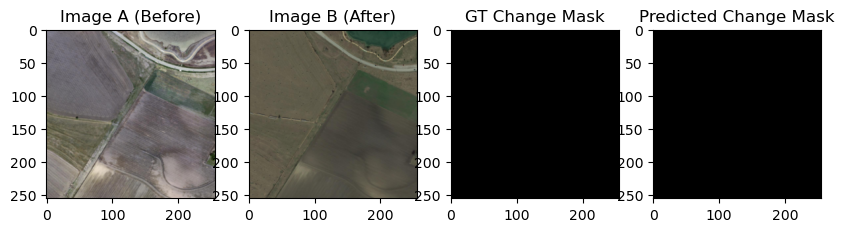

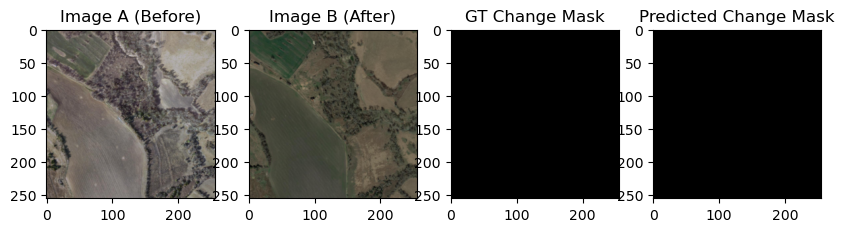

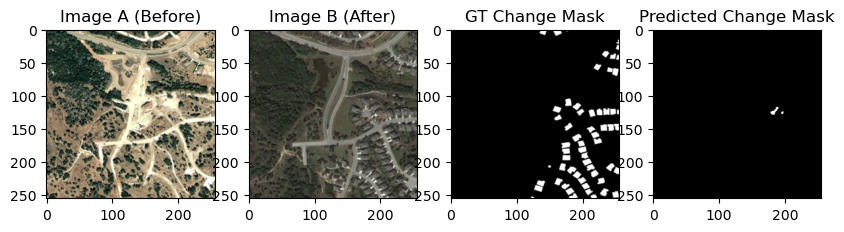

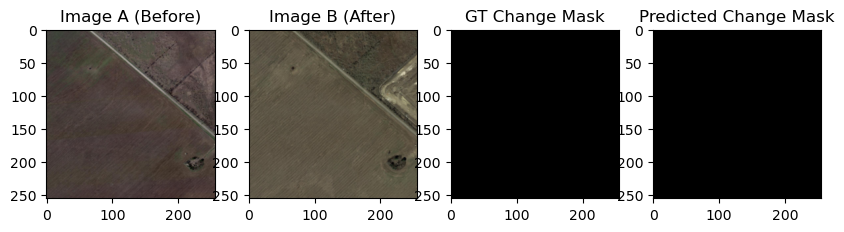

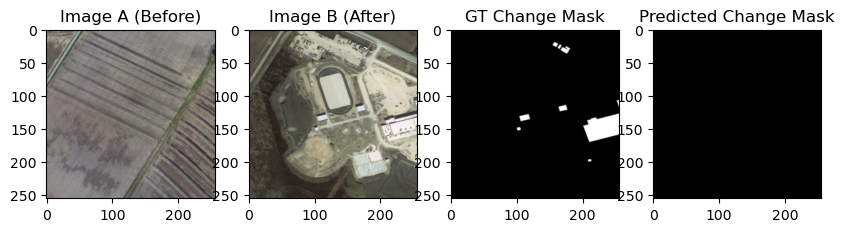

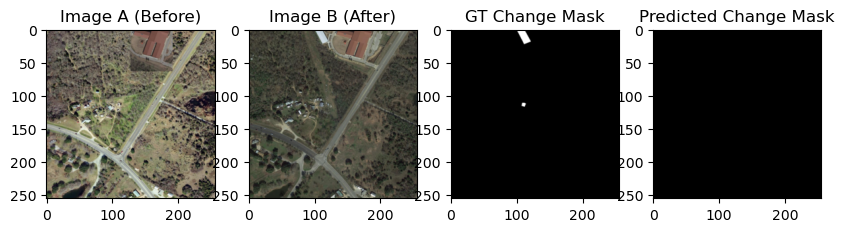

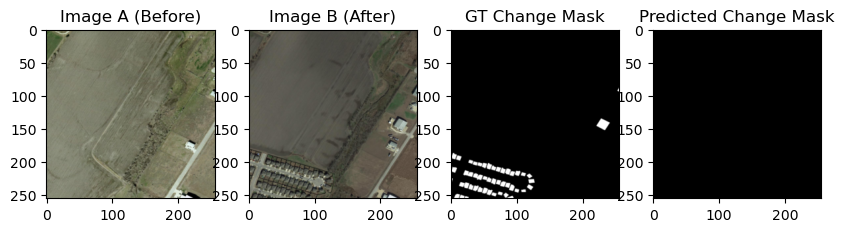

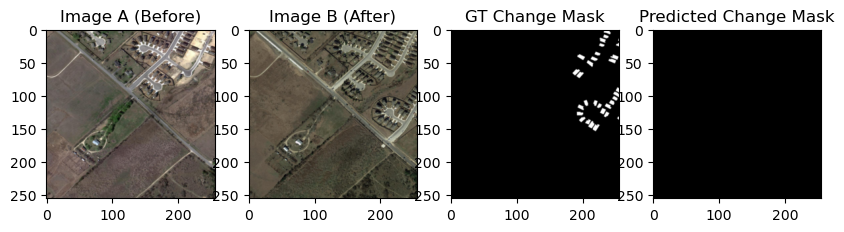

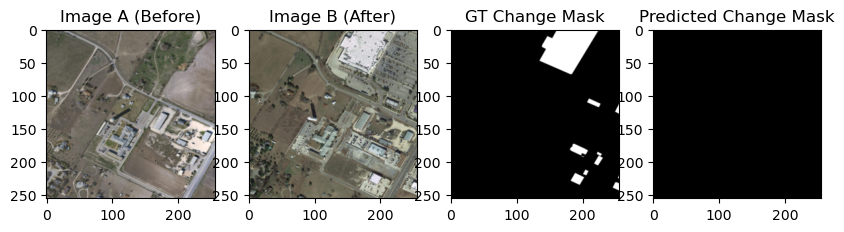

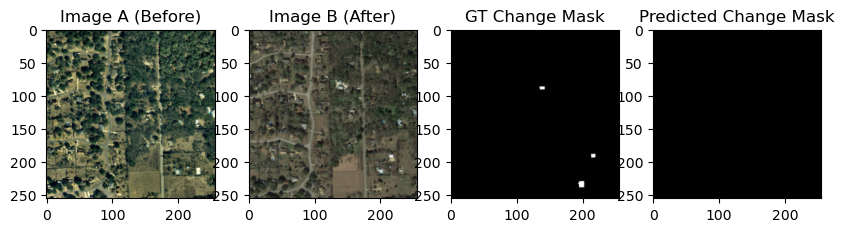

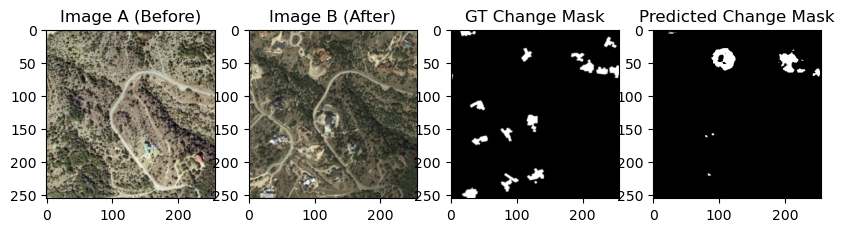

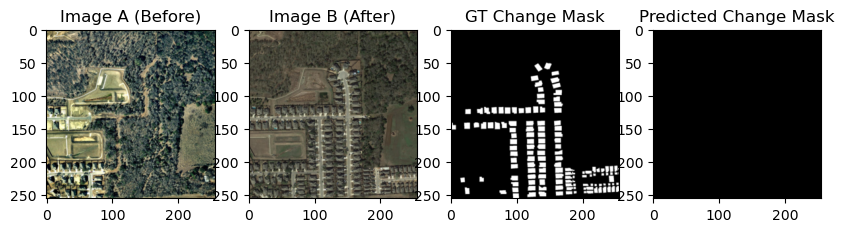

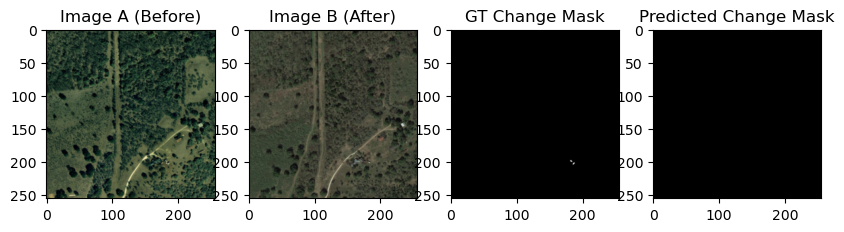

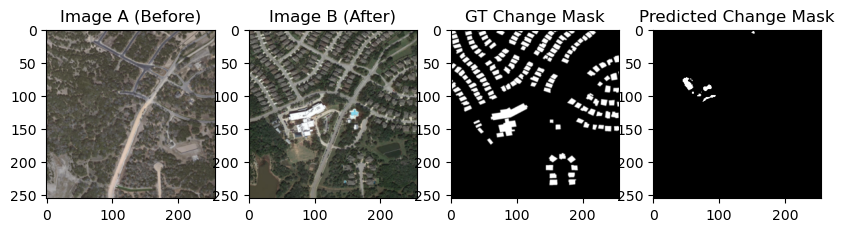

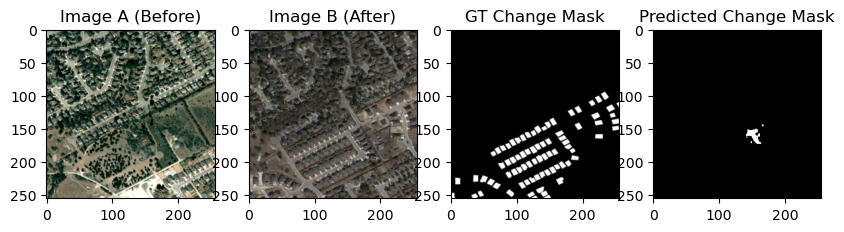

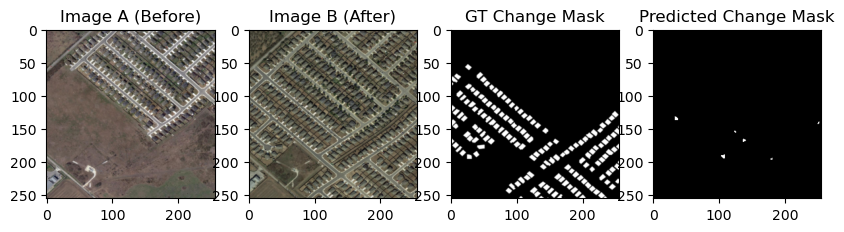

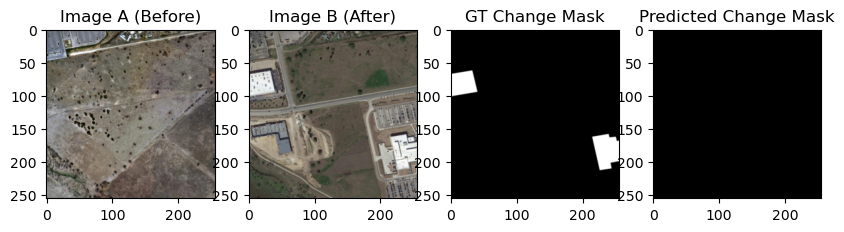

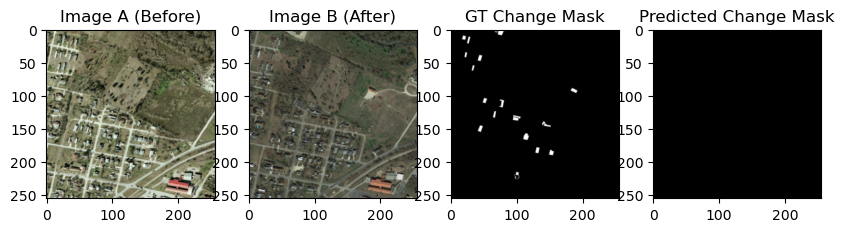

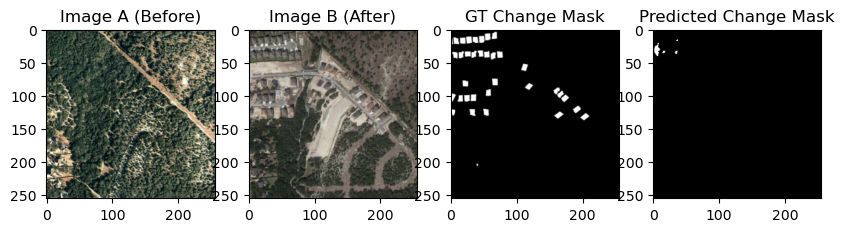

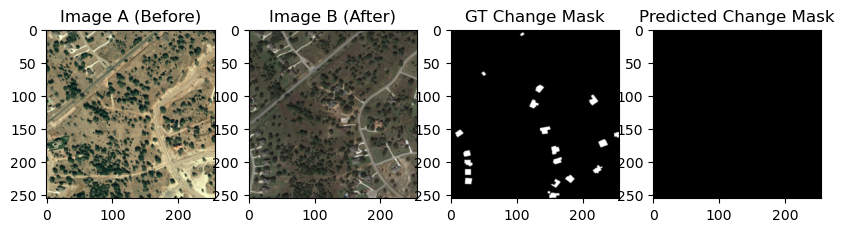

In [247]:
visualize_test_results(model, val_loader, num_examples=5)